<a href="https://colab.research.google.com/github/yucellgereklioglu/datasciencework/blob/main/Student_Habits_vs_Academic_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import r2_score,root_mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,StackingRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/content/student_habits_performance.csv')
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


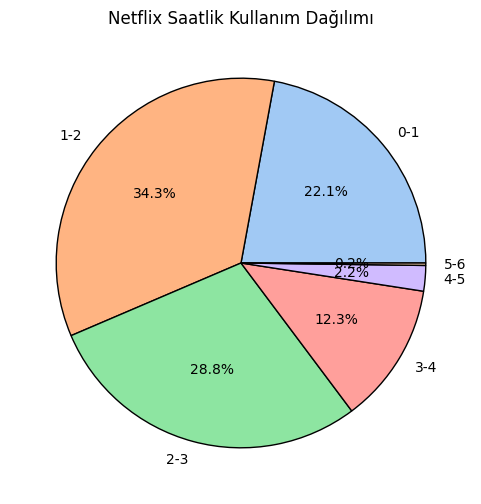

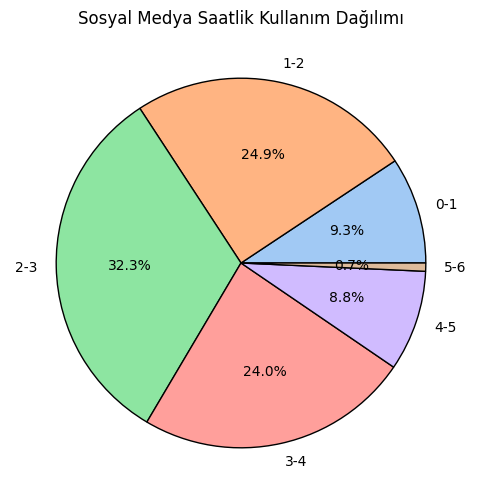

In [4]:
df['netflix_range'] = pd.cut(df['netflix_hours'], bins=[0, 1, 2, 3, 4, 5, 6], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6'])
plt.figure(figsize=(6, 6))
df['netflix_range'].value_counts().sort_index().plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Netflix Saatlik Kullanım Dağılımı")
plt.ylabel('')
plt.show()
df['social_range'] = pd.cut(df['social_media_hours'], bins=[0, 1, 2, 3, 4, 5, 6], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6'])

plt.figure(figsize=(6, 6))
df['social_range'].value_counts().sort_index().plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Sosyal Medya Saatlik Kullanım Dağılımı")
plt.ylabel('')
plt.show()


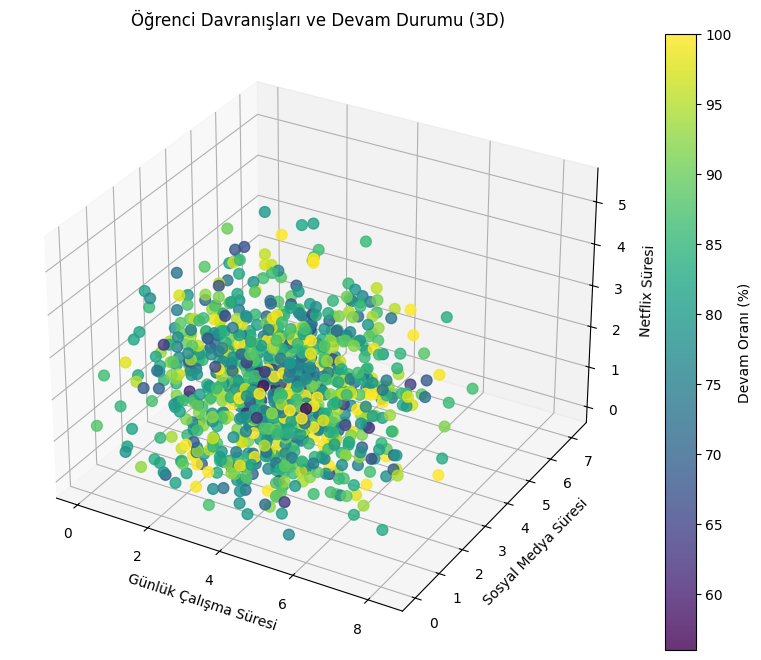

In [5]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df['study_hours_per_day'],
    df['social_media_hours'],
    df['netflix_hours'],
    c=df['attendance_percentage'],
    cmap='viridis',
    s=60,
    alpha=0.8
)
ax.set_xlabel('Günlük Çalışma Süresi')
ax.set_ylabel('Sosyal Medya Süresi')
ax.set_zlabel('Netflix Süresi')
ax.set_title('Öğrenci Davranışları ve Devam Durumu (3D)')
cbar = plt.colorbar(scatter)
cbar.set_label('Devam Oranı (%)')
plt.show()


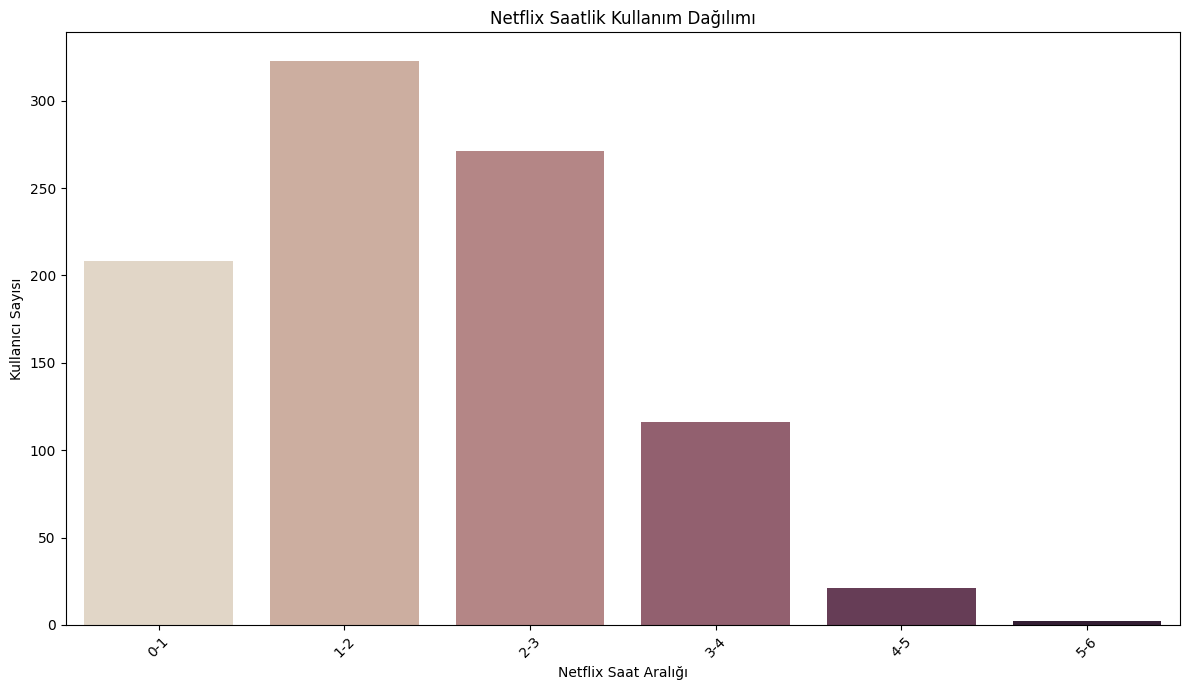

In [6]:
plt.figure(figsize=(12, 7))
sns.countplot(
    x="netflix_range",
    data=df,
    palette="ch:.25"
)
plt.title("Netflix Saatlik Kullanım Dağılımı")
plt.xlabel("Netflix Saat Aralığı")
plt.ylabel("Kullanıcı Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


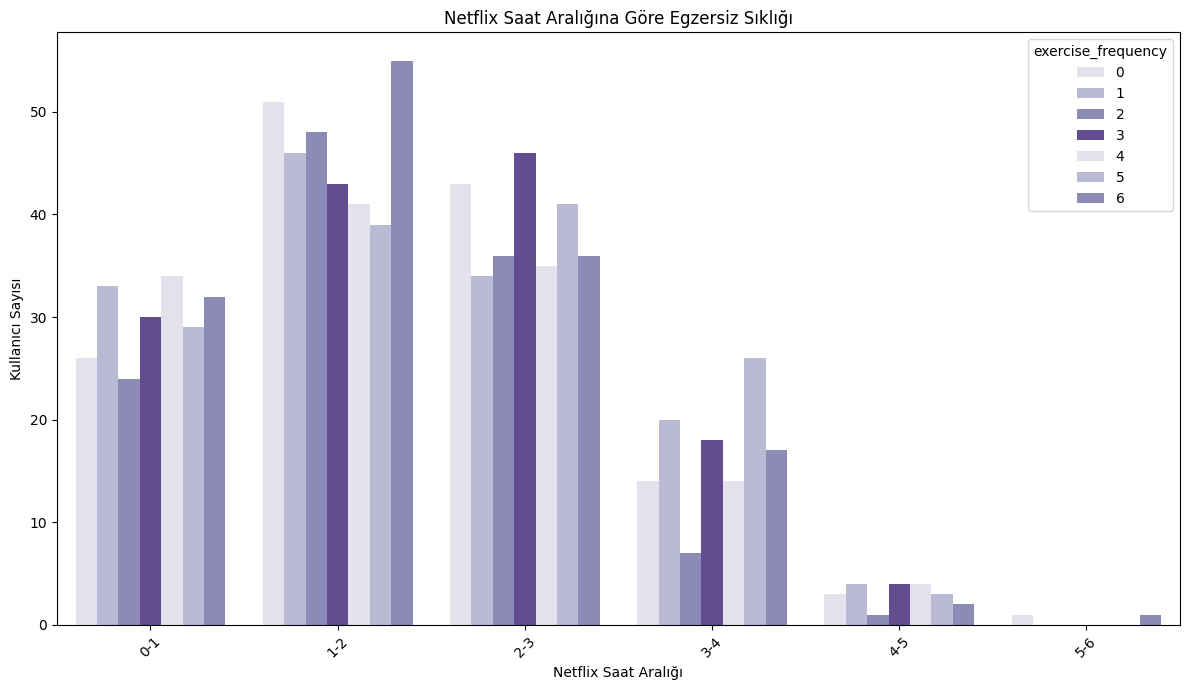

In [7]:
plt.figure(figsize=(12, 7))
sns.countplot(
    x="netflix_range",
    hue="exercise_frequency",
    data=df,
    palette=sns.color_palette("Purples", n_colors=4)
)

plt.title("Netflix Saat Aralığına Göre Egzersiz Sıklığı")
plt.xlabel("Netflix Saat Aralığı")
plt.ylabel("Kullanıcı Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
le=LabelEncoder()
df['gender']=le.fit_transform(df['gender'])
df['part_time_job']=le.fit_transform(df['part_time_job'])
df['diet_quality']=le.fit_transform(df['diet_quality'])
df['parental_education_level']=le.fit_transform(df['parental_education_level'])
df['internet_quality']=le.fit_transform(df['internet_quality'])
df['extracurricular_participation']=le.fit_transform(df['extracurricular_participation'])


In [9]:
y = df['exam_score']
X = df.drop(['exam_score', 'netflix_range', 'social_range','student_id'], axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 7, 9, 11, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', 0.8]
}
rf = RandomForestRegressor(random_state=42)
rfrandom = RandomizedSearchCV(estimator=rf, param_distributions=rf_params,
                               n_iter=40, cv=3, verbose=0, random_state=42, n_jobs=-1, scoring='r2')
rfrandom.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9, 11, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         0.8],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='r2')

In [16]:
xgb_params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.07],
    'max_depth': [3, 7],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0.21],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.5, 1.2]
}
xgb=XGBRegressor(random_state=42)
xgbrandom = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params,
                               n_iter=40, cv=3, verbose=0, random_state=42, n_jobs=-1, scoring='r2')
xgbrandom.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8],
                                        'gamma': [0.21],
                                        'learning_rate': [0.01, 0.07],
                                        'max_depth': [3, 7],
                                        'n_estimators': [500, 1000],
                                        'reg_alpha': [0, 0.1],
                                        'reg_lambda': [0.5, 1.2],
                                        'subsample': [0.7, 0.8]},
                   random_state=42, scoring='r2')

In [18]:
cat_params = {
    'iterations': [100],
    'learning_rate': [0.03],
    'depth': [6],
    'l2_leaf_reg': [1, 5],
    'border_count': [32],
    'loss_function': ['RMSE']
}
cat=CatBoostRegressor(random_state=42)
catrandom = RandomizedSearchCV(estimator=cat, param_distributions=cat_params,
                               n_iter=40, cv=3, verbose=0, random_state=42, n_jobs=-1, scoring='r2')
catrandom.fit(X_train, y_train)

0:	learn: 16.7565951	total: 47.2ms	remaining: 4.67s
1:	learn: 16.4386205	total: 47.8ms	remaining: 2.34s
2:	learn: 16.1514173	total: 48.3ms	remaining: 1.56s
3:	learn: 15.8643578	total: 48.7ms	remaining: 1.17s
4:	learn: 15.5548329	total: 49.2ms	remaining: 936ms
5:	learn: 15.2739471	total: 49.7ms	remaining: 779ms
6:	learn: 14.9909930	total: 50.3ms	remaining: 668ms
7:	learn: 14.7290725	total: 50.8ms	remaining: 584ms
8:	learn: 14.4376475	total: 51.2ms	remaining: 518ms
9:	learn: 14.1614279	total: 51.7ms	remaining: 465ms
10:	learn: 13.9227556	total: 52.2ms	remaining: 422ms
11:	learn: 13.6658113	total: 52.7ms	remaining: 387ms
12:	learn: 13.4713580	total: 53.2ms	remaining: 356ms
13:	learn: 13.2276031	total: 53.6ms	remaining: 329ms
14:	learn: 13.0092711	total: 54.1ms	remaining: 307ms
15:	learn: 12.7857150	total: 54.7ms	remaining: 287ms
16:	learn: 12.5950568	total: 55.1ms	remaining: 269ms
17:	learn: 12.3880101	total: 55.7ms	remaining: 254ms
18:	learn: 12.1947783	total: 56.2ms	remaining: 239ms
19:

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7c83d5568190>,
                   n_iter=40, n_jobs=-1,
                   param_distributions={'border_count': [32], 'depth': [6],
                                        'iterations': [100],
                                        'l2_leaf_reg': [1, 5],
                                        'learning_rate': [0.03],
                                        'loss_function': ['RMSE']},
                   random_state=42, scoring='r2')

In [21]:
best_rf = rfrandom.best_estimator_
best_xgb = xgbrandom.best_estimator_
best_cat = catrandom.best_estimator_
stack=StackingRegressor(estimators=[('rf', best_rf), ('xgb', best_xgb), ('cat', best_cat)], final_estimator=LinearRegression())
stack.fit(X_train, y_train)

0:	learn: 16.7565951	total: 848us	remaining: 84ms
1:	learn: 16.4386205	total: 1.79ms	remaining: 87.6ms
2:	learn: 16.1514173	total: 2.28ms	remaining: 73.8ms
3:	learn: 15.8643578	total: 2.77ms	remaining: 66.5ms
4:	learn: 15.5548329	total: 3.31ms	remaining: 62.9ms
5:	learn: 15.2739471	total: 3.85ms	remaining: 60.4ms
6:	learn: 14.9909930	total: 4.37ms	remaining: 58.1ms
7:	learn: 14.7290725	total: 4.9ms	remaining: 56.3ms
8:	learn: 14.4376475	total: 5.45ms	remaining: 55.1ms
9:	learn: 14.1614279	total: 5.94ms	remaining: 53.5ms
10:	learn: 13.9227556	total: 6.39ms	remaining: 51.7ms
11:	learn: 13.6658113	total: 6.87ms	remaining: 50.4ms
12:	learn: 13.4713580	total: 7.35ms	remaining: 49.2ms
13:	learn: 13.2276031	total: 7.9ms	remaining: 48.5ms
14:	learn: 13.0092711	total: 8.38ms	remaining: 47.5ms
15:	learn: 12.7857150	total: 8.93ms	remaining: 46.9ms
16:	learn: 12.5950568	total: 9.46ms	remaining: 46.2ms
17:	learn: 12.3880101	total: 10ms	remaining: 45.6ms
18:	learn: 12.1947783	total: 10.5ms	remaining

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=11,
                                                     max_features=0.8,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weight...
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7c83ed05fe90>)],
                  final_estimator=LinearRegression())

In [24]:
X_meta = np.zeros((X_train.shape[0], 3))
kf = KFold(n_splits=6, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    rf.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)
    cat.fit(X_tr, y_tr)
    X_meta[val_idx, 0] = rf.predict(X_val)
    X_meta[val_idx, 1] = xgb.predict(X_val)
    X_meta[val_idx, 2] = cat.predict(X_val)
meta_model = Ridge()
meta_model.fit(X_meta, y_train)
y_predmeta=meta_model.predict(X_meta)
print(r2_score(y_train,y_predmeta))
print(root_mean_squared_error(y_train,y_predmeta))

Görüntülenen çıkış son 5000 satıra kısaltıldı.
6:	learn: 15.0493281	total: 7.99ms	remaining: 1.13s
7:	learn: 14.7511532	total: 9.03ms	remaining: 1.12s
8:	learn: 14.4100516	total: 10.1ms	remaining: 1.11s
9:	learn: 14.1355561	total: 11ms	remaining: 1.09s
10:	learn: 13.8660732	total: 12.1ms	remaining: 1.08s
11:	learn: 13.5610724	total: 13ms	remaining: 1.07s
12:	learn: 13.2891967	total: 13.9ms	remaining: 1.05s
13:	learn: 13.0156327	total: 14.9ms	remaining: 1.05s
14:	learn: 12.7811088	total: 15.8ms	remaining: 1.04s
15:	learn: 12.5098454	total: 16.8ms	remaining: 1.03s
16:	learn: 12.2665086	total: 17.8ms	remaining: 1.03s
17:	learn: 12.0323829	total: 18.9ms	remaining: 1.03s
18:	learn: 11.8222328	total: 19.8ms	remaining: 1.02s
19:	learn: 11.6085709	total: 20.8ms	remaining: 1.02s
20:	learn: 11.4101832	total: 21.7ms	remaining: 1.01s
21:	learn: 11.2019144	total: 22.7ms	remaining: 1.01s
22:	learn: 11.0149944	total: 23.7ms	remaining: 1.01s
23:	learn: 10.8334326	total: 24.7ms	remaining: 1s
24:	learn:

Text(0.5, 1.0, 'Ridge Meta Model predict performace')

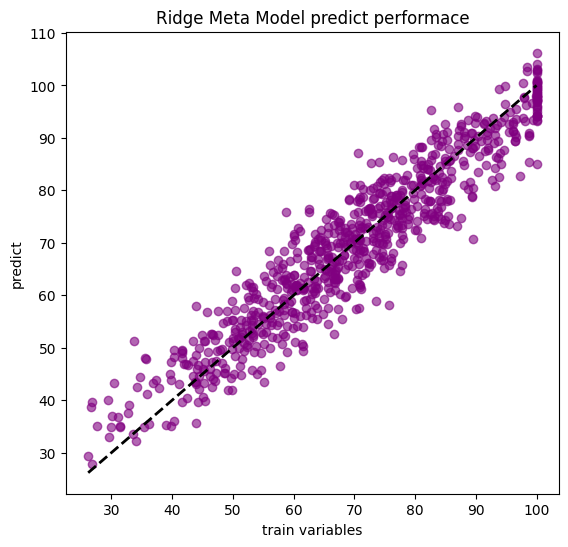

In [29]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_predmeta, alpha=0.6, color='purple', label='Ridge Meta Model')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel("train variables")
plt.ylabel("predict")
plt.title("Ridge Meta Model predict performace")

In [31]:
X_meta_train = np.column_stack([
    rf.predict(X_train),
    xgb.predict(X_train),
    cat.predict(X_train)
])
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_meta_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_meta_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)
X_meta_test = np.column_stack([
    rf.predict(X_test),
    xgb.predict(X_test),
    cat.predict(X_test)
])
y_pred_nn = model.predict(X_meta_test).flatten()

from sklearn.metrics import r2_score, mean_squared_error
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)
print("Neural Network:")
print(f"RMSE: {rmse_nn}")
print(f"R2 Score: {r2_nn}")


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5096.9883 - mae: 69.2379 - val_loss: 4322.8853 - val_mae: 64.1084
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5045.8784 - mae: 68.9533 - val_loss: 4037.5598 - val_mae: 62.1993
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4622.8516 - mae: 66.1380 - val_loss: 3494.2466 - val_mae: 58.0605
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3942.0872 - mae: 61.2136 - val_loss: 3159.4187 - val_mae: 55.2100
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3419.0295 - mae: 57.2145 - val_loss: 2166.4614 - val_mae: 45.5825
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2538.8669 - mae: 48.7080 - val_loss: 1682.0212 - val_mae: 39.2257
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1808.0845 - mae: 39.8709 - val_loss: 1242.1147 - val_mae: 32.3813
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1111.6421 - mae: 29.1840 - val_loss: 916.0985 - val_mae: 26.2017
E

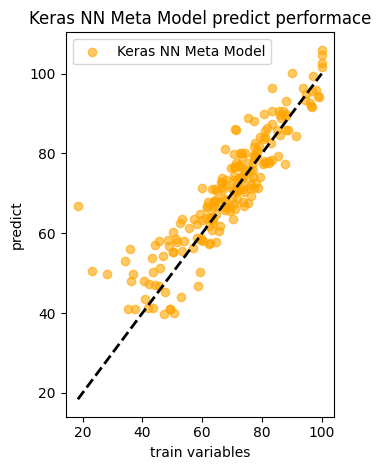

In [32]:
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_nn, alpha=0.6, color='orange', label='Keras NN Meta Model')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("train variables")
plt.ylabel("predict")
plt.title("Keras NN Meta Model predict performace")
plt.legend()
plt.tight_layout()
plt.show()

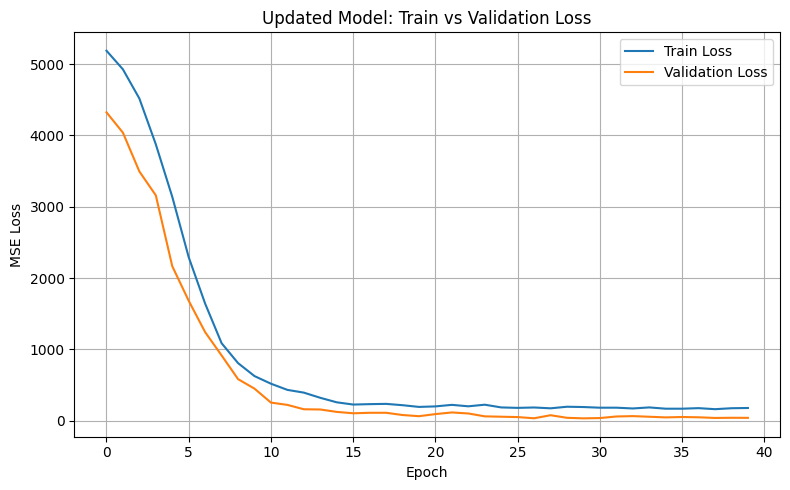

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Updated Model: Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
